In [1]:
__depends__ = [
    "../data/sr15_scenarios/sr15_scenarios.csv",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UVIC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_BERN.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_LLNL.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CCSM1.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CLIMBER.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_MPI.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_FRCGC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UMD2.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_HADLEY.CFG",
    "utils_openscm.py",
    "utils_plotting.py",
    "utils_magcfg.py",
    "utils_config.py",
]
__dest__ = [
    "../outputs/offline_budget_runs_tcre.h5",
    "../outputs/offline_budget_runs_zec.h5",
    "../outputs/offline_budget_runs_no_permafrost.h5",
    "../outputs/offline_budget_runs_co2_only.h5",
]

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Cell above is scons stuff to make sure our dependency tree work. We put a renaming in the cell below to make it clearer what is what.

In [3]:
SCENARIO_PATH = __depends__[0]
CARBON_CYCLE_FILES = {
    "UVIC": __depends__[1],
    "BERN": __depends__[2],
    "LLNL": __depends__[3],
    "CCSM1": __depends__[4],
    "CLIMBER": __depends__[5],
    "MPI": __depends__[6],
    "FRCGC": __depends__[7],
    "UMD2": __depends__[8],
    "HADLEY": __depends__[9],
}
OUTPUT_RUNS_TCRE = __dest__[0]
OUTPUT_RUNS_ZEC = __dest__[1]
OUTPUT_RUNS_NO_PERMAFROST = __dest__[2]
OUTPUT_RUNS_CO2_ONLY = __dest__[3]

<IPython.core.display.Javascript object>

# Offline Budget Runs

In this notebook we perform the runs for the calculation of our offline budget.

## Imports

In [4]:
import os
from os.path import join
import datetime
import copy
from distutils.util import strtobool

import numpy as np
from openscm.scmdataframe import df_append, ScmDataFrame
from pymagicc import zero_emissions, rcp45, MAGICC6
from pymagicc.io import MAGICCData

from utils_openscm import save_scmdataframe, run_magicc6_with_scenarios
from utils_magcfg import get_carbon_cycle_cfgs
from utils_config import TEST_RUN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting config

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from utils_plotting import setup

setup()

<IPython.core.display.Javascript object>

## Constants

In [6]:
SHOW_PLOTS = True and not strtobool(
    os.getenv("CI", "False")
)  # turn on if using the notebooks interactively

CARBON_CYCLES = get_carbon_cycle_cfgs(CARBON_CYCLE_FILES)

<IPython.core.display.Javascript object>

## Read in scenarios

In [7]:
scenarios = ScmDataFrame(SCENARIO_PATH)

<IPython.core.display.Javascript object>

### TCRE calculation

The TCRE is calculated from a prescribed 70-year 1%/yr increasing CO$_2$ concentration experiment. At the end of this experiment, CO$_2$ concentrations have approximately doubled. For our own interest in the zero emissions commitment, we switch to a zero emissions scenario thereafter. 

We perform this calculation for multiple carbon cycle tunings for robustness analysis in later assessment.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


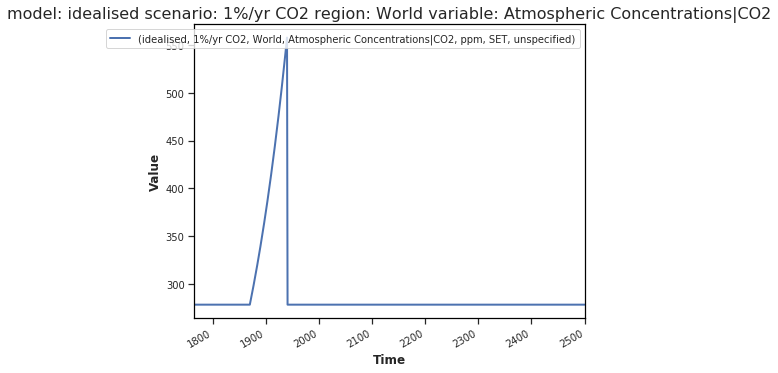

<IPython.core.display.Javascript object>

In [8]:
time = zero_emissions["time"]

rise_start_year = 1870
rise_years = 70
rise_start_idx = [t.year for t in time].index(rise_start_year)
rise_end_idx = rise_start_idx + rise_years
co2_concs = 278 * np.ones_like(time)
co2_concs[rise_start_idx : rise_end_idx + 1] = 278 * np.logspace(
    0, 70, num=rise_years + 1, base=1.01
)

co2_concs = MAGICCData(
    co2_concs,
    index=time,
    columns={
        "scenario": ["1%/yr CO2"],
        "model": ["idealised"],
        "climate_model": ["unspecified"],
        "variable": ["Atmospheric Concentrations|CO2"],
        "unit": ["ppm"],
        "todo": ["SET"],
        "region": ["World"],
    },
)

time = co2_concs["time"]
co2_concs.metadata = {"header": "1%/yr atmospheric CO2 concentration increase"}
if SHOW_PLOTS:
    co2_concs.line_plot(x="time")

In [9]:
scen = copy.deepcopy(zero_emissions)
scen.set_meta("1%/yr CO2", "scenario")
scen.set_meta("Idealised", "model")
tcre_diagnosis = []
with MAGICC6() as magicc:
    co2_conc_filename = "1PCT_CO2_CONC.IN"
    co2_concs.write(join(magicc.run_dir, co2_conc_filename), magicc.version)
    for cc, cc_config in CARBON_CYCLES.items():
        print(cc)
        settings = {
            "file_co2_conc": co2_conc_filename,
            "co2_switchfromconc2emis_year": rise_start_year + rise_years,
            "co2_tempfeedback_switch": 1,
            "co2_tempfeedback_yrstart": rise_start_year,
            "co2_fertilization_yrstart": rise_start_year,
            "rf_total_runmodus": "CO2",
            "rf_total_constantafteryr": max(time).year,
            "endyear": max(time).year,
            "out_inverseemis": 1,
            **cc_config,
        }
        magicc.set_config(**{k: v for k, v in settings.items() if k != "endyear"})
        run_results = magicc.run(scen, endyear=settings["endyear"])
        for k, v in settings.items():
            run_results.set_meta(v, k)
        run_results.set_meta(cc, name="carbon_cycle_tuning")

        tcre_diagnosis.append(run_results)

tcre_diagnosis = df_append(tcre_diagnosis)
save_scmdataframe(tcre_diagnosis.filter(region="World"), OUTPUT_RUNS_TCRE)

UVIC


Ignoring input data which is not required for .SCEN file


BERN
LLNL
CCSM1
CLIMBER
MPI
FRCGC
UMD2
HADLEY
default


numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


<IPython.core.display.Javascript object>

In [10]:
tcre_diagnosis.filter(variable="Surface Temperature", region="World").timeseries()

time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        1765-01-01 00:00:00  \
model     scenario  region variable            unit carbon_cycle_tuning climate_model co2_detrituspool_initial co2_feedbackfactor_detritus co2_feedbackfactor_gpp co2_feedbackfactor_respiration co2_feedbackfactor_soil co2_fertilization_factor co2_fertilization_method co2_fertilization_yrstart co2_fraction_detritus_2_soil co2_fraction_gpp_2_detritus co2_fraction_gpp_2_plant co2_fraction_plant_2_detritus co2_gpp_initial co2_plantpool_initial co2_respiration_initial co2_soilpool_initial co2_switchfromconc2emis_year co2_tempfeedback_switch co2_tempfeedback_yrstart endyear file_co2_conc    oceancc_scale_gasxchange oceancc_scale_impulseresponse oceancc_tempfeedback out_inverseemis rf_total_constantafteryr rf_total_runmodus todo                        
Idealised 1%/yr CO2 World  Surface Temperature K    FRCGC               MAGICC6       32.6689                   0.399463                    0.024352              -0.199991                      0.223615                0.262525                 1.998614                 1870                      0.061806                      2.264556e-01               0.659712                 0.998999                      48.1558         484.2099              8.908823                592.1234             1940                         1                       1870                     2500    1PCT_CO2_CONC.IN 1.285673                 1.119896                       4.120232e-05        1               2500                     CO2               N/A                   0.0   
                                                    MPI                 MAGICC6       72.1718                  -0.057642                   -0.030182              -0.024221                      0.068020                1.054845                 1.000004                 1870                      0.001000                      5.732079e-01               0.218303                 0.998857                      53.2807         351.4974              9.856929                1308.1130            1940                         1                       1870                     2500    1PCT_CO2_CONC.IN 2.000000                 1.226110                       8.849392e-08        1               2500                     CO2               N/A                   0.0   
                                                    CCSM1               MAGICC6       56.7203                  -0.279810                    0.008768              -0.016097                      0.152235                0.439670                 1.811535                 1870                      0.001035                      3.472068e-01               0.484813                 0.999000                      66.5843         870.4989              12.318100               1028.0560            1940                         1                       1870                     2500    1PCT_CO2_CONC.IN 0.658993                 1.677268                       3.516323e-02        1               2500                     CO2               N/A                   0.0   
                                                    LLNL                MAGICC6       103.1582                 -0.222341                   -0.000422              -0.007911                      0.218282                1.034578

<IPython.core.display.Javascript object>

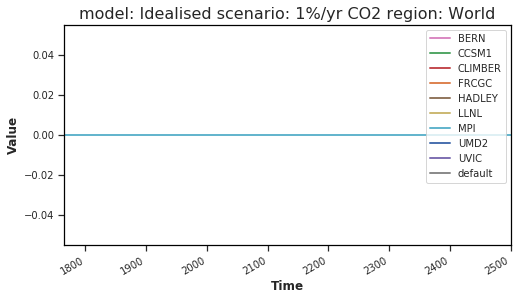

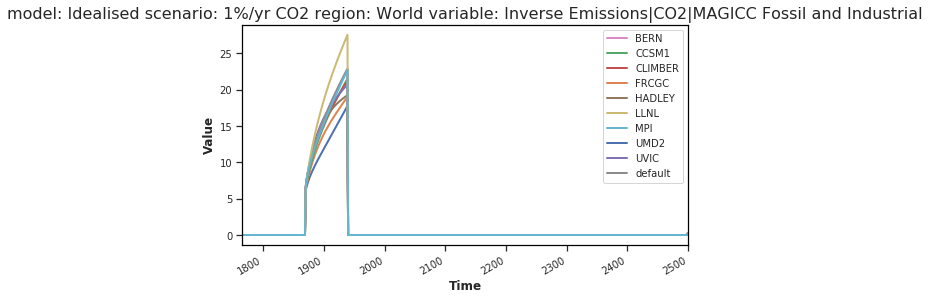

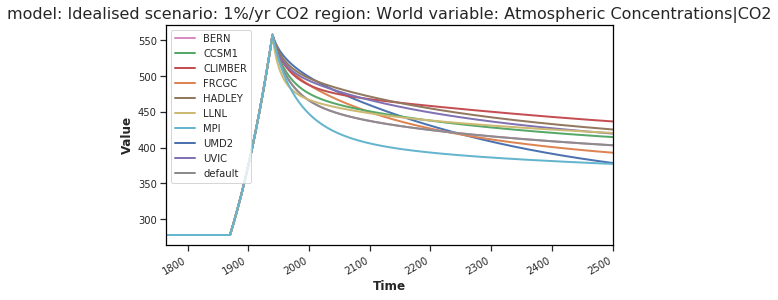

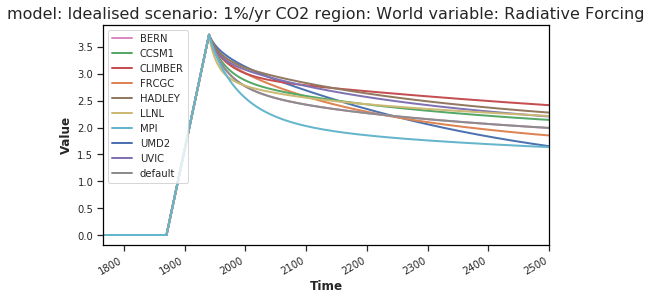

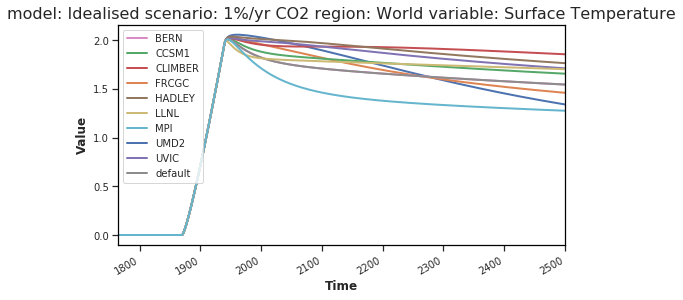

<IPython.core.display.Javascript object>

In [11]:
# quick, ugly check this is doing something sensible
if SHOW_PLOTS:
    tcre_diagnosis.filter(variable="Emis*CO2*", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Inverse Emis*CO2*", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Atmos*Conc*CO2", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Radiative Forcing", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )
    tcre_diagnosis.filter(variable="Surface Temperature", region="World").line_plot(
        x="time", figsize=(8, 4.5), color="carbon_cycle_tuning"
    )

### ZEC

SR1.5 mentions a number of studies for its zero-emissions commitment assessment. Below we include them and our comments/summary of the experiments they performed.

Matthews and Caldeira 2008: instantaneous 50, 200, 500 and 2000 GtC pulses; historical CO2 concentrations until 2000 then RCP8.5 emissions with zero drops at 50, 200, 500 and 2000 GtC cumulative from 2005; historical CO2 concentrations until 2000 then linear drop with cumulative totals of 50, 200, 500 and 2000 GtC. Results show stabilisation with abrupt drops but temperature fit results imply a slightly positive ZEC for a smooth approach to a temperature target. In any case, they seem to have explored the question of ZEC in stabilisation scenarios somewhat already.

Lowe et al 2009: SRES A2 and then abrupt zero at 2012, 2050 or 2100. One extra scenario which has exponential drop in emissions. All seem to suggest negative ZEC.

Gillet et al 2011: abrupt zero at 2010 or 2100 from SRES A2

Collins et al 2013 (i.e. IPCC AR5 Ch.12, Section 12.5.2): variety of sources (including ones above but also more), conclude ZEC is slightly negative or zero (with positive bump for aerosols). Figure 12.44 is for abrupt zeros (although in case of RCP2.6 that isn't doing much for CO2) and exhibits negative ZEC. 

#### This study

Almost all of the studies above are CO$_2$ only and non-CO$_2$ is assessed elsewhere in the SR1.5 framework. To follow this, here we run RCP4.5 CO$_2$, global only emissions up until 2050 and then zero-emissions thereafter.

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


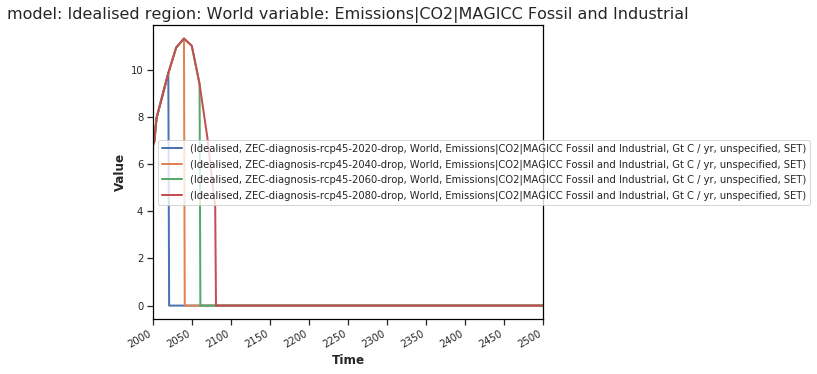

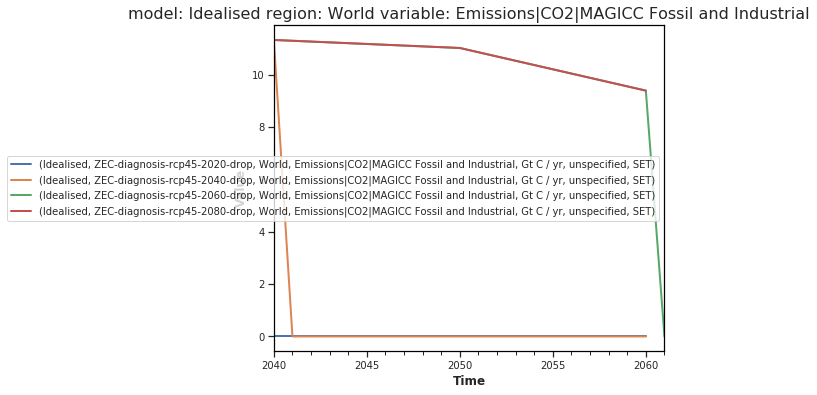

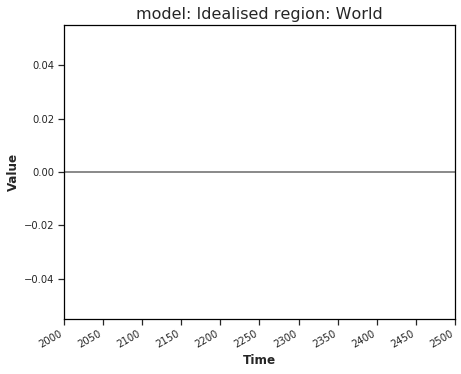

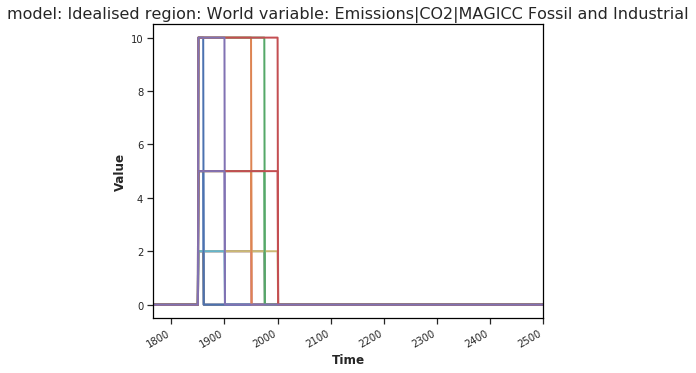

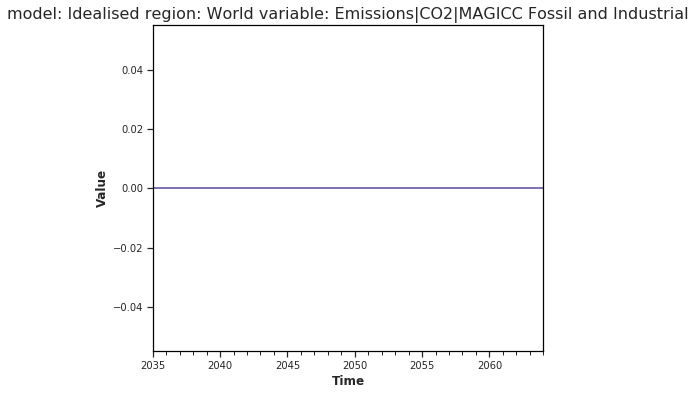

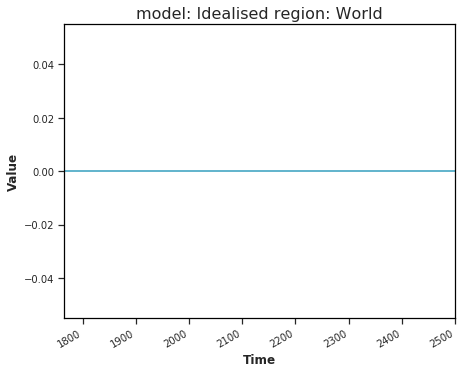

<IPython.core.display.Javascript object>

In [12]:
time = zero_emissions["time"]
zec_scens = []
for dropyear in np.arange(2020, 2081, 20):
    df = rcp45.filter(region="World", year=range(2000, 3000)).timeseries()
    df[datetime.datetime(dropyear + 1, 1, 1)] = 0
    df = df[sorted(df.columns)]
    df.loc[
        (
            df.index.get_level_values("variable")
            == "Emissions|CO2|MAGICC Fossil and Industrial"
        ),
        [t.year > dropyear for t in df.columns],
    ] = 0
    df.loc[
        (
            df.index.get_level_values("variable")
            != "Emissions|CO2|MAGICC Fossil and Industrial"
        ),
        :,
    ] = 0

    scen = MAGICCData(df)
    scen.set_meta("ZEC-diagnosis-rcp45-{}-drop".format(dropyear), "scenario")
    scen.set_meta(
        "Idealised", "model"
    )  # have to fill, None and nan don't work see https://github.com/openclimatedata/openscm/issues/114
    zec_scens.append(scen)

zec_scens = df_append(zec_scens)

zec_pulses = []
for pulseemissions in [2, 5, 10]:
    for pulselength in [10, 50, 100, 125, 150]:
        df = zero_emissions.filter(region="World").timeseries()
        df = df[sorted(df.columns)]
        df.loc[
            (
                df.index.get_level_values("variable")
                == "Emissions|CO2|MAGICC Fossil and Industrial"
            ),
            [1850 < t.year <= 1850 + pulselength for t in df.columns],
        ] = pulseemissions

        scen = MAGICCData(df)
        scen.set_meta(
            "ZEC-diagnosis-pulse-{}-for-{}-years".format(pulseemissions, pulselength),
            "scenario",
        )
        scen.set_meta(
            "Idealised", "model"
        )  # have to fill, None and nan don't work see https://github.com/openclimatedata/openscm/issues/114
        zec_pulses.append(scen)

zec_pulses = df_append(zec_pulses)

if SHOW_PLOTS:
    zec_scens.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
    zec_scens.filter(variable="Em*CO2*Fossil*", year=range(2035, 2065)).line_plot(
        x="time"
    )
    zec_scens.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time")

    zec_pulses.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
    zec_pulses.filter(variable="Em*CO2*Fossil*", year=range(2035, 2065)).line_plot(
        x="time"
    )
    zec_pulses.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time")

In [13]:
ZEC_SETTINGS = {
    "endyear": zec_scens["time"].max().year,
    "rf_total_constantafteryr": 5000,
    "rf_total_runmodus": "CO2",
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
}

<IPython.core.display.Javascript object>

In [14]:
for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    settings = {**ZEC_SETTINGS, **cc_config}
    zec_diagnosis = run_magicc6_with_scenarios(zec_scens, settings)
    zec_diagnosis = zec_diagnosis.append(
        run_magicc6_with_scenarios(
            zec_pulses, settings, from_zero=True, test_run=TEST_RUN
        )
    )
    zec_diagnosis.set_meta(cc, "carbon_cycle_tuning")

    out_run_file = (
        OUTPUT_RUNS_ZEC
        if cc == "default"
        else OUTPUT_RUNS_ZEC.replace(".h5", "_{}.h5".format(cc))
    )

    save_scmdataframe(zec_diagnosis.filter(region="World"), out_run_file)

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| |                               #                   | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |           #                                       | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                       #                           | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                   #               | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                               #   | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                          #        | 5 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
\ |                              #                    | 6 Elapsed Time: 0:00:07Ignoring input data which

BERN


| |                              #                    | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |           #                                       | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                       #                           | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                   #               | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                               #   | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                          #        | 5 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
\ |                             #                     | 6 Elapsed Time: 0:00:07Ignoring input data which

LLNL


| |                              #                    | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |            #                                      | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                         #                         | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                      #            | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                  #| 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                                     #             | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                        #                          | 6 Elapsed Time: 0:00:07Ignoring input data which

CCSM1


| |                                #                  | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |             #                                     | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                          #                        | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                       #           | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                 # | 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                                    #              | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                        #                          | 6 Elapsed Time: 0:00:07Ignoring input data which

CLIMBER


| |                              #                    | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |           #                                       | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                       #                           | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                   #               | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                #  | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                        #          | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                            #                      | 6 Elapsed Time: 0:00:07Ignoring input data which

MPI


| |                              #                    | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |            #                                      | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                        #                          | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                    #              | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                 # | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                        #          | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                           #                       | 6 Elapsed Time: 0:00:07Ignoring input data which

FRCGC


| |                               #                   | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |            #                                      | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                        #                          | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                     #             | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                 # | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                        #          | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                           #                       | 6 Elapsed Time: 0:00:07Ignoring input data which

UMD2


| |                               #                   | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |            #                                      | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                        #                          | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                    #              | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                #  | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                         #         | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                             #                     | 6 Elapsed Time: 0:00:07Ignoring input data which

HADLEY


| |                              #                    | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |            #                                      | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                        #                          | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                    #              | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                #  | 4 Elapsed Time: 0:00:04Ignoring input data which is not required for .SCEN file
- |                                        #          | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                            #                      | 6 Elapsed Time: 0:00:07Ignoring input data which

default


| |                               #                   | 3 Elapsed Time: 0:00:03
/ |#                                                  | 0 Elapsed Time: 0:00:00Ignoring input data which is not required for .SCEN file
- |            #                                      | 1 Elapsed Time: 0:00:01Ignoring input data which is not required for .SCEN file
\ |                         #                         | 2 Elapsed Time: 0:00:02Ignoring input data which is not required for .SCEN file
| |                                      #            | 3 Elapsed Time: 0:00:03Ignoring input data which is not required for .SCEN file
/ |                                                  #| 4 Elapsed Time: 0:00:05Ignoring input data which is not required for .SCEN file
- |                                     #             | 5 Elapsed Time: 0:00:06Ignoring input data which is not required for .SCEN file
\ |                        #                          | 6 Elapsed Time: 0:00:07Ignoring input data which

<IPython.core.display.Javascript object>

INFO:root:>=13 labels, not applying legend
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


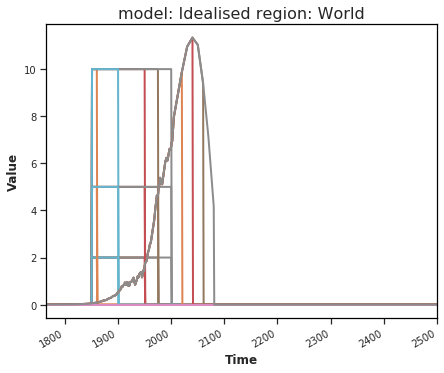

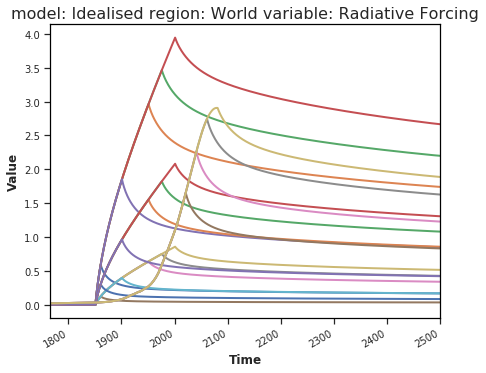

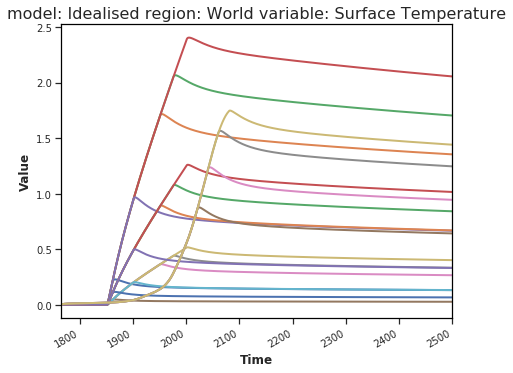

<IPython.core.display.Javascript object>

In [15]:
zec_diagnosis.filter(variable="Emis*CO2*", region="World").line_plot(x="time")
zec_diagnosis.filter(variable="Radiative Forcing", region="World").line_plot(
    x="time", color="scenario"
)
zec_diagnosis.filter(variable="Surface Temperature", region="World").line_plot(
    x="time", color="scenario"
)

### All drivers without permafrost

In [16]:
NO_PERMAFROST_SETTINGS = {  # defaults
    "endyear": 2105,
    "rf_total_runmodus": "all",
    "pf_apply": 0,
    "out_permafrost": 1,
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
}

for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    settings = {**NO_PERMAFROST_SETTINGS, **cc_config}
    no_permafrost = run_magicc6_with_scenarios(scenarios, settings, test_run=TEST_RUN)
    no_permafrost.set_meta(cc, "carbon_cycle_tuning")
    # filter out data which applies to scenario only i.e. drop data after 2100
    out_run_file = (
        OUTPUT_RUNS_NO_PERMAFROST
        if cc == "default"
        else OUTPUT_RUNS_NO_PERMAFROST.replace(".h5", "_{}.h5".format(cc))
    )

    save_scmdataframe(
        no_permafrost.filter(year=range(1, 2101), region="World"), out_run_file
    )

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| |       #                                         | 410 Elapsed Time: 0:05:43
/ |#                                                  | 0 Elapsed Time: 0:00:00

BERN


| |  #                                              | 410 Elapsed Time: 0:05:43
/ |#                                                  | 0 Elapsed Time: 0:00:00

LLNL


| |                             #                   | 410 Elapsed Time: 0:05:45
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCSM1


| |             #                                   | 410 Elapsed Time: 0:05:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

CLIMBER


| |                      #                          | 410 Elapsed Time: 0:05:45
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI


| |                                  #              | 410 Elapsed Time: 0:05:39
/ |#                                                  | 0 Elapsed Time: 0:00:00

FRCGC


| |          #                                      | 410 Elapsed Time: 0:05:41
/ |#                                                  | 0 Elapsed Time: 0:00:00

UMD2


| |                #                                | 410 Elapsed Time: 0:05:41
/ |#                                                  | 0 Elapsed Time: 0:00:00

HADLEY


| |              #                                  | 410 Elapsed Time: 0:05:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

default


| | #                                               | 410 Elapsed Time: 0:05:42


<IPython.core.display.Javascript object>

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
INFO:root:>=13 labels, not applying legend


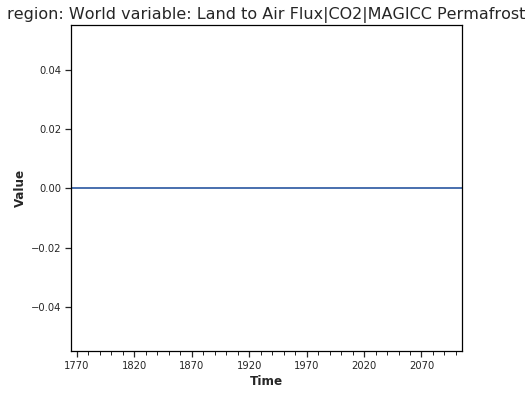

<IPython.core.display.Javascript object>

In [17]:
no_permafrost.filter(variable="*Permafrost*", region="World").line_plot(
    x="time", color="model"
)

### CO$_2$ only without permafrost

Here we examine the effect of non-CO$_2$ emissions from 2010 onwards. For each scenario, we do this by performing an experiment where we run with CO$_2$ emissions only and no permafrost.

In [18]:
CO2_ONLY_SETTINGS = {
    "endyear": 2105,
    "pf_apply": 0,
    "out_permafrost": 1,
    "rf_total_runmodus": "CO2",
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
}

for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    settings = {**CO2_ONLY_SETTINGS, **cc_config}
    co2_only = run_magicc6_with_scenarios(scenarios, settings, test_run=TEST_RUN)
    co2_only.set_meta(cc, "carbon_cycle_tuning")
    # filter out data which applies to scenario only i.e. drop data after 2100
    out_run_file = (
        OUTPUT_RUNS_CO2_ONLY
        if cc == "default"
        else OUTPUT_RUNS_CO2_ONLY.replace(".h5", "_{}.h5".format(cc))
    )

    save_scmdataframe(
        co2_only.filter(year=range(1, 2101), region="World"), out_run_file
    )

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| |                         #                       | 410 Elapsed Time: 0:05:45
/ |#                                                  | 0 Elapsed Time: 0:00:00

BERN


| |                                             #   | 410 Elapsed Time: 0:05:47
/ |#                                                  | 0 Elapsed Time: 0:00:00

LLNL


| |    #                                            | 410 Elapsed Time: 0:05:43
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCSM1


| |          #                                      | 410 Elapsed Time: 0:05:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

CLIMBER


| | #                                               | 410 Elapsed Time: 0:05:43
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI


| | #                                               | 410 Elapsed Time: 0:05:43
/ |#                                                  | 0 Elapsed Time: 0:00:00

FRCGC


| |                           #                     | 410 Elapsed Time: 0:05:45
/ |#                                                  | 0 Elapsed Time: 0:00:00

UMD2


| |          #                                      | 410 Elapsed Time: 0:05:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

HADLEY


| |              #                                  | 410 Elapsed Time: 0:05:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

default


| |#                                                | 410 Elapsed Time: 0:05:43


<IPython.core.display.Javascript object>

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


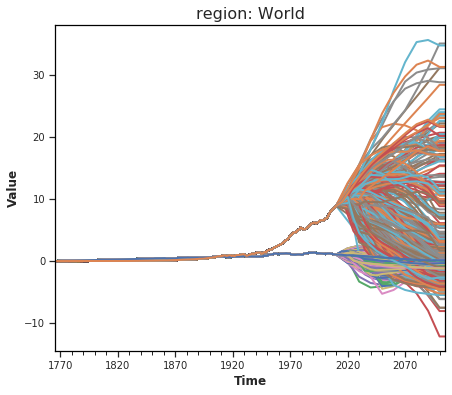

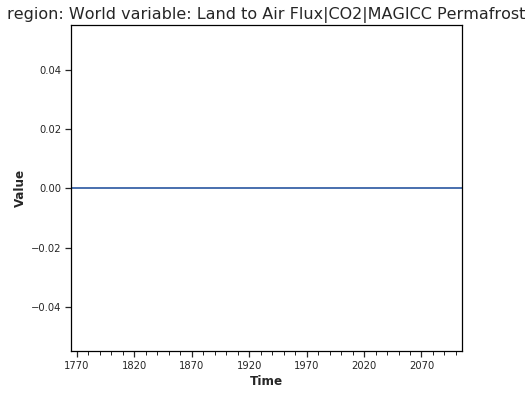

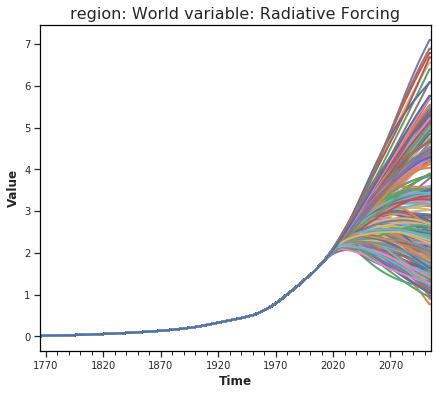

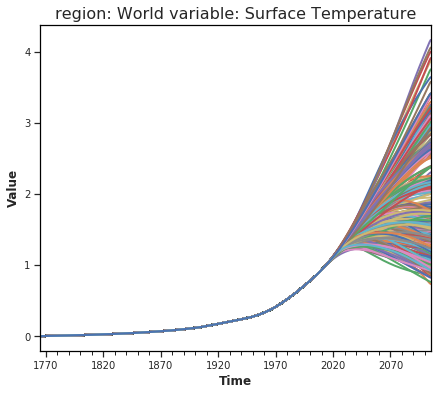

<IPython.core.display.Javascript object>

In [19]:
co2_only.filter(variable="Emis*CO2*", region="World").line_plot(x="time")
co2_only.filter(variable="*Permafrost", region="World").line_plot(x="time")
co2_only.filter(variable="Radiative Forcing", region="World").line_plot(x="time")
co2_only.filter(variable="Surface Temperature", region="World").line_plot(x="time")